# Example 15: Catalog of published nonlinear curves

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata

In [ ]:
pystrata.site._load_published_curves()
models = pystrata.site.PUBLISHED_CURVES

In [ ]:
df = pd.DataFrame(models).T.reset_index(drop=True)
df[["source", "suffix"]] = df.name.str.split(",", expand=True)

## Plot published different curves

In [ ]:
print("\n".join(df["source"].unique()))

Vucetic & Dobry (91)
EPRI (93)
GEI (83)
GeoMatrix (1990)
Idriss (1990)
Imperial Valley Soils
Iwasaki
Peninsular Range
Seed & Idriss


In [ ]:
def plot_group(group, title="", cycle_colors=False, label=False):
    fig, axes = plt.subplots(nrows=2, sharex=True, subplot_kw=dict(xscale="log"))

    for i, row in group.reset_index(drop=True).iterrows():
        for ax, prop in zip(axes, ["mod_reduc", "damping"]):
            if pd.isna(row[prop]):
                continue

            ax.plot(
                row[prop]["strains"],
                row[prop]["values"],
                color=f"C{i}" if cycle_colors else "C0",
                label=row["suffix"].strip() if label else None,
            )

    axes[0].set(ylabel="G/G$_{max}$")
    if title:
        axes[0].set_title(title)

    axes[1].set(ylabel="Damping (dec)", xlabel="Strain (dec)")

    if label:

        def get_labels(ax):
            return sorted([line.get_label() for line in ax.get_lines()])

        labels = [get_labels(ax) for ax in axes]
        if len(labels[1]):
            # Prefer to label damping
            axes[1].legend(
                loc="upper left",
                fontsize="x-small",
                ncols=2 if len(labels[1]) > 7 else 1,
            )
        # Add to shear-mod if different
        if labels[0] != labels[1] and len(labels[0]):
            axes[0].legend(
                loc="lower left",
                fontsize="x-small",
                ncols=2 if len(labels[0]) > 7 else 1,
            )

    fig.tight_layout()
    return fig, axes

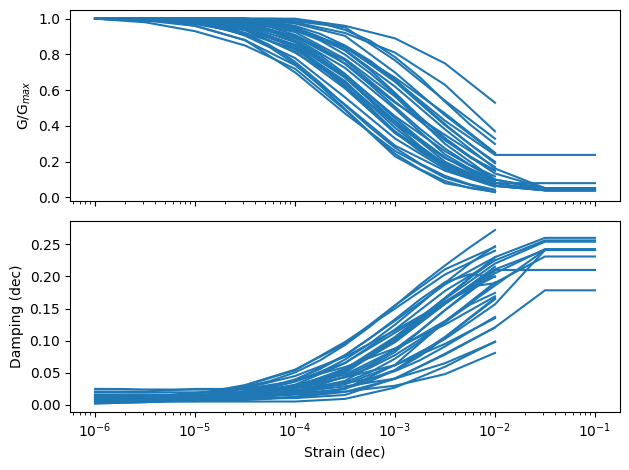

In [ ]:
fig, axes = plot_group(df, cycle_colors=False, label=False)
plt.show(fig)

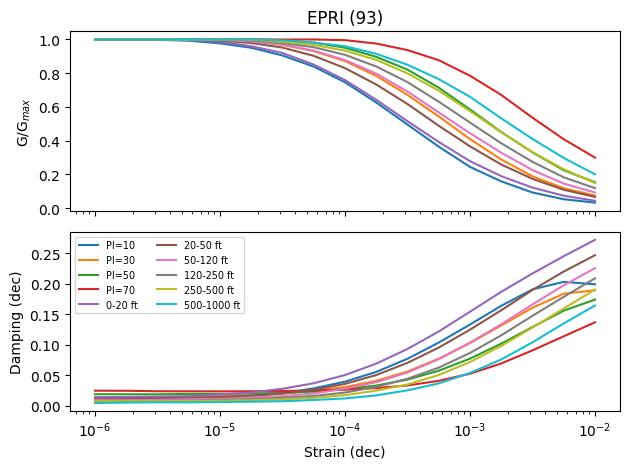

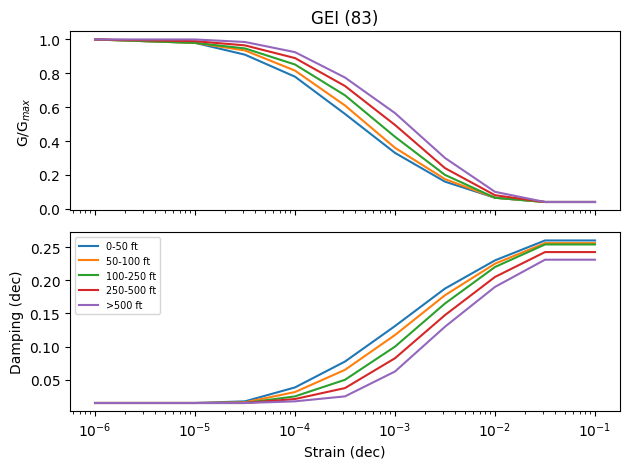

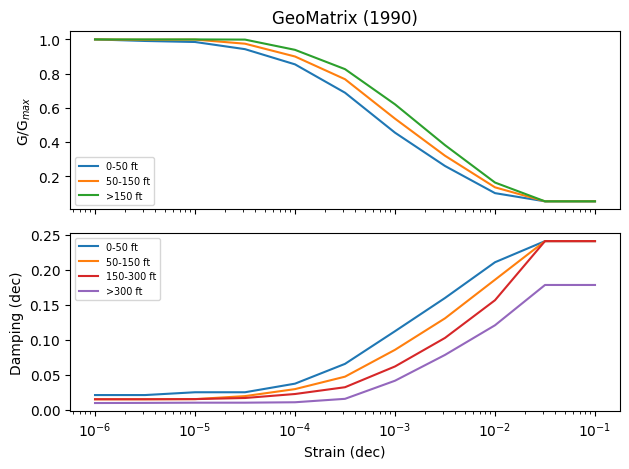

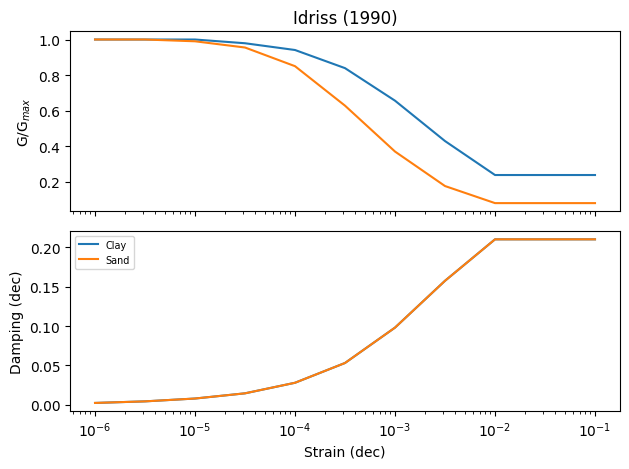

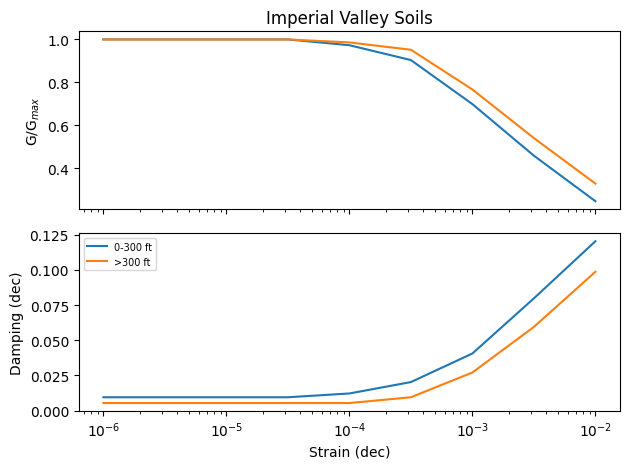

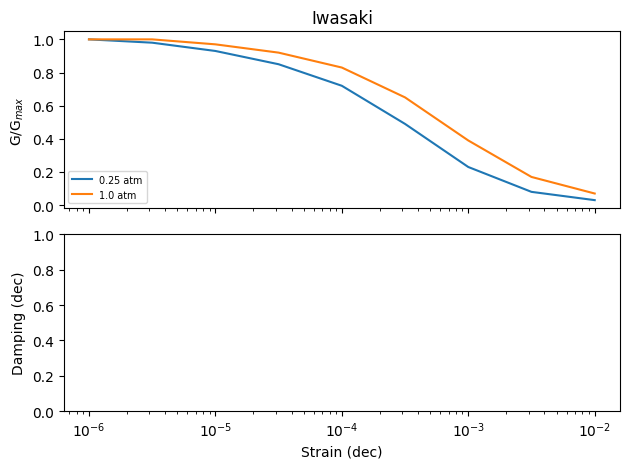

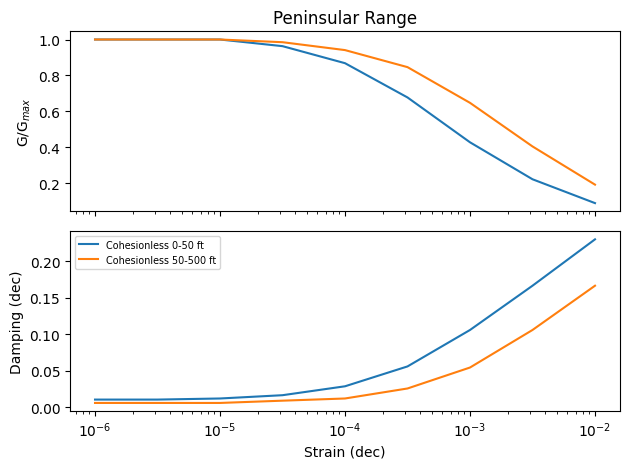

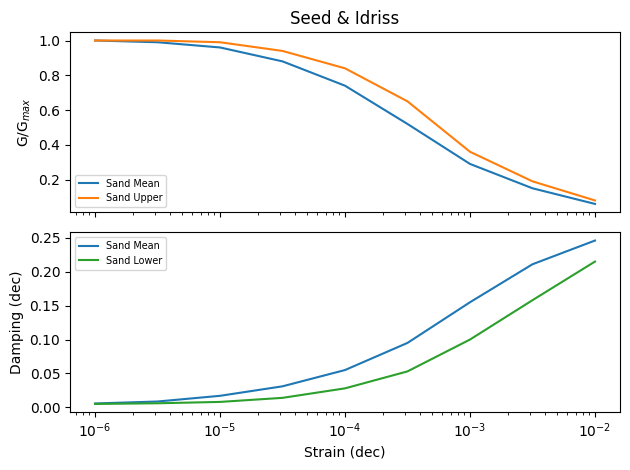

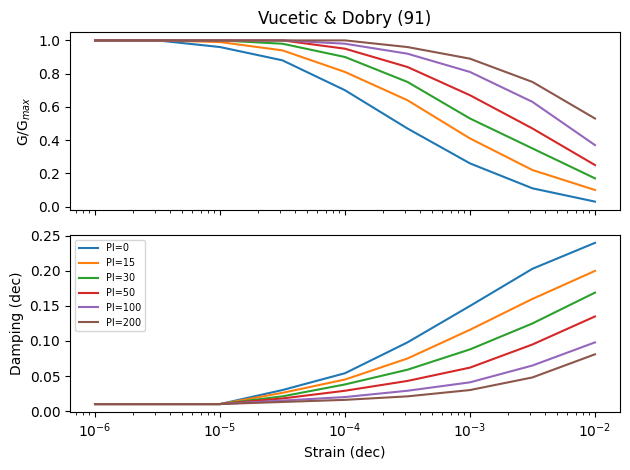

In [ ]:
for name, group in df.groupby("source"):
    fig, axes = plot_group(group, name, cycle_colors=True, label=True)
    plt.show(fig)

## Compare Darendeli and Wang and Stokoe (2022)

In [ ]:
plas_index = np.r_[0, 15, 30, 60]
strains = np.geomspace(0.0001, 1)

In [ ]:
darendelis = [
    pystrata.site.DarendeliSoilType(unit_wt=16, plas_index=pi, ocr=1, stress_mean=101.3)
    for pi in plas_index
]

wangs = [
    pystrata.site.WangSoilType(
        "clayey_soil",
        unit_wt=16,
        plas_index=pi,
        ocr=1,
        stress_mean=101.3,
        void_ratio=0.7,
        fines_cont=70,
        water_cont=25,
    )
    for pi in plas_index
]

[Text(0.5, 0, 'Shear Strain (%)'), Text(0, 0.5, 'Damping (%)')]

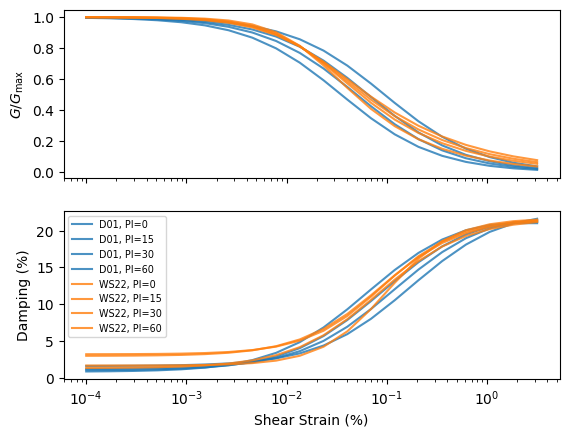

In [ ]:
fig, axes = plt.subplots(nrows=2, sharex=True, subplot_kw={"xscale": "log"})

for color, models in [("C0", darendelis), ("C1", wangs)]:
    for pi, m in zip(plas_index, models):
        name = "D01" if isinstance(m, pystrata.site.DarendeliSoilType) else "WS22"

        for ax, attr in zip(axes, ["mod_reduc", "damping"]):
            scale = 100 if attr == "damping" else 1
            ax.plot(
                100 * getattr(m, attr).strains,
                scale * getattr(m, attr).values,
                label=f"{name}, PI={pi}",
                color=color,
                ls="-",
                alpha=0.8,
            )

axes[0].set(ylabel="$G/G_{\\max}$")
axes[1].legend(fontsize="x-small", loc="upper left")
axes[1].set(xlabel="Shear Strain (%)", ylabel="Damping (%)")

## Example usage of nonlinear curves

To create a soil profile, use the `pystrata.site.SoilType.from_published()` method. The protential curve names are here:

In [ ]:
print("\n".join(pystrata.site.PUBLISHED_CURVES.keys()))

Vucetic & Dobry (91), PI=0
Vucetic & Dobry (91), PI=15
Vucetic & Dobry (91), PI=30
Vucetic & Dobry (91), PI=50
Vucetic & Dobry (91), PI=100
Vucetic & Dobry (91), PI=200
EPRI (93), PI=10
EPRI (93), PI=30
EPRI (93), PI=50
EPRI (93), PI=70
EPRI (93), 0-20 ft
EPRI (93), 20-50 ft
EPRI (93), 50-120 ft
EPRI (93), 120-250 ft
EPRI (93), 250-500 ft
EPRI (93), 500-1000 ft
GEI (83), 0-50 ft
GEI (83), 50-100 ft
GEI (83), 100-250 ft
GEI (83), 250-500 ft
GEI (83), >500 ft
GeoMatrix (1990), 0-50 ft
GeoMatrix (1990), 50-150 ft
GeoMatrix (1990), >150 ft
GeoMatrix (1990), 150-300 ft
GeoMatrix (1990), >300 ft
Idriss (1990), Clay
Idriss (1990), Sand
Imperial Valley Soils, 0-300 ft
Imperial Valley Soils, >300 ft
Iwasaki, 0.25 atm
Iwasaki, 1.0 atm
Peninsular Range, Cohesionless 0-50 ft
Peninsular Range, Cohesionless 50-500 ft
Seed & Idriss, Sand Mean
Seed & Idriss, Sand Upper
Seed & Idriss, Sand Lower


In [ ]:
# Here we can create it with one model for both
st = pystrata.site.SoilType.from_published(unit_wt=18, model="Seed & Idriss, Sand Mean")
st

In [ ]:
# Here we can create it with two different models
st = pystrata.site.SoilType.from_published(
    unit_wt=18,
    model="Seed & Idriss, Sand Mean",
    model_damping="Seed & Idriss, Sand Lower",
)
st

Create a simple profile using Seed & Idriss (Sand Mean) for all curves.

In [ ]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.SoilType.from_published(
                unit_wt=18.0, model="Seed & Idriss, Sand Mean"
            ),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.SoilType.from_published(
                unit_wt=18.0, model="Seed & Idriss, Sand Mean"
            ),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.SoilType.from_published(
                unit_wt=18.0, model="Seed & Idriss, Sand Mean"
            ),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
).auto_discretize()

In [ ]:
m = pystrata.motion.SourceTheoryRvtMotion(7.0, 5, "wna")
m.calc_fourier_amps()

In [ ]:
calc = pystrata.propagation.EquivalentLinearCalculator()

In [ ]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),
    ]
)

In [ ]:
calc(m, profile, profile.location("outcrop", index=-1))
outputs(calc)

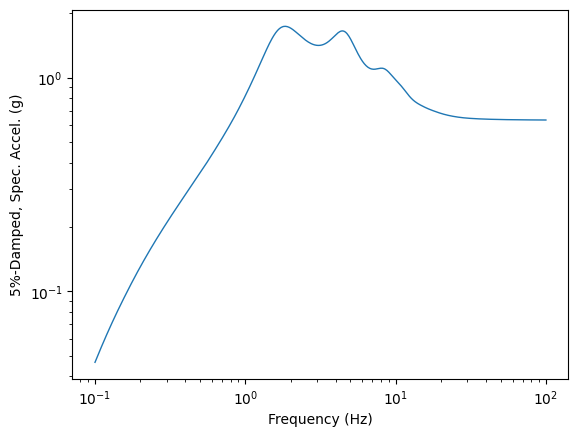

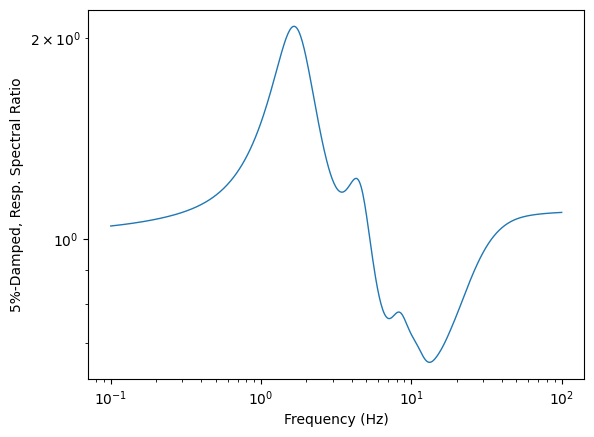

In [ ]:
for o in outputs[:-1]:
    ax = o.plot()